In [1]:
# File paths 

data_dir = './Firefighting-Device-Detection-6'
model_path = "checkpoint_100.tar"

In [ ]:

%pip install ipykernel==6.29.4
%pip install python-dotenv==1.0.1
%pip install simclr==1.0.2
%pip install roboflow==1.1.27
%pip install lightning==2.2.2
%pip install ipywidgets==8.1.2

!wget https://github.com/Spijkervet/SimCLR/releases/download/1.2/$model_path

In [2]:
# Config: https://github.com/Spijkervet/SimCLR/blob/master/config/config.yaml

config = {
    "image_size": 224,
    "workers": 8,
    "resnet": "resnet50",
    "projection_dim": 64,
    "max_boxes": 50,
    "trials": 5,
    "epochs": 5,
    "batch_size": [2, 64],
    "weight_decay": [1e-8, 1e2],
}

In [3]:
# Fixed SimCLR transforms: https://github.com/Spijkervet/SimCLR/blob/master/simclr/modules/transformations/simclr.py

import torchvision


class TransformsSimCLR:
    """
    A stochastic data augmentation module that transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """

    def __init__(self, size):
        s = 1
        color_jitter = torchvision.transforms.ColorJitter(
            0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
        )
        self.train_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomResizedCrop(size=size),
                torchvision.transforms.RandomHorizontalFlip(),  # with 0.5 probability
                torchvision.transforms.RandomApply([color_jitter], p=0.8),
                torchvision.transforms.RandomGrayscale(p=0.2),
                torchvision.transforms.ToTensor(),
            ]
        )

        self.test_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(size=(size, size)),  # Single int didn't work
                torchvision.transforms.ToTensor(),
            ]
        )

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

In [4]:
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import lightning as L
from roboflow import Roboflow
from dotenv import load_dotenv
import os
import yaml
load_dotenv()


class DetectionDataset(Dataset):
    def __init__(self, split, transform):
        path = os.path.join(data_dir, split)
        images_dir = os.path.join(path, "images")
        labels_dir = os.path.join(path, "labels")
        self.image_paths = glob.glob(os.path.join(images_dir, "*.jpg"))
        self.label_paths = glob.glob(os.path.join(labels_dir, "*.txt"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        annotations = []
        with open(label_path, 'r') as file:
            for line in file:
                class_id, x_min, y_min, x_max, y_max = map(float, line.strip().split())
                annotations.append((int(class_id), x_min, y_min, x_max, y_max))

        # Pad if necessary
        if len(annotations) > config["max_boxes"]:
            annotations = annotations[:config["max_boxes"]]
        elif len(annotations) < config["max_boxes"]:
            annotations += [(0, 0, 0, 0, 0)] * (config["max_boxes"] - len(annotations))

        class_ids = torch.tensor([a[0] for a in annotations], dtype=torch.long)
        boxes = torch.tensor([a[1:] for a in annotations], dtype=torch.float32)
        
        return image, class_ids, boxes
    

class DetectionDataModule(L.LightningDataModule):
    def __init__(self, num_workers, batch_size):
        super().__init__()
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.num_classes = 0

    def prepare_data(self):
        rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))
        project = rf.workspace("yaid-pzikt").project("firefighting-device-detection")
        version = project.version(6)
        dataset = version.download("yolov8")
        print(dataset.__dict__)
        
        with open(os.path.join(data_dir, 'data.yaml'), 'r') as f:
            data = yaml.safe_load(f)
        labels = data.get('names', [])
        self.num_classes = data.get('nc', [])
        assert len(labels) == self.num_classes
        print(f"Labels: {labels}")
        print(f"Number of classes: {self.num_classes}")

    def setup(self, stage=None):
        transform = TransformsSimCLR(size=config["image_size"])
        self.train_dataset = DetectionDataset(split="train", transform=transform.train_transform)
        self.valid_dataset = DetectionDataset(split="valid", transform=transform.test_transform)
        self.test_dataset = DetectionDataset(split="test", transform=transform.test_transform)

    def collate_fn(self, batch):
        images, class_ids, boxes = zip(*batch)
        images = torch.stack(images)
        class_ids = torch.stack(class_ids)
        boxes = torch.stack(boxes)
        return images, (class_ids, boxes)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=self.num_workers, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True, num_workers=self.num_workers, collate_fn=self.collate_fn)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True, num_workers=self.num_workers, collate_fn=self.collate_fn)

    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True, num_workers=self.num_workers, collate_fn=self.collate_fn)

In [5]:
# Loss function

import torch.nn as nn

def detection_loss(pred_classes, pred_boxes, true_labels, true_boxes):    
    flat_pred_classes = pred_classes.view(-1, pred_classes.size(-1))  # Flatten to [batch_size * max_boxes, num_classes]
    flat_true_labels = true_labels.view(-1)  # Flatten to [batch_size * max_boxes]
    
    valid_mask = true_labels > 0

    valid_indices = valid_mask.view(-1)
    class_loss = nn.CrossEntropyLoss()(flat_pred_classes[valid_indices], flat_true_labels[valid_indices])
    
    valid_boxes = valid_mask.unsqueeze(-1).expand_as(true_boxes) 
    loc_loss = nn.SmoothL1Loss()(pred_boxes[valid_boxes], true_boxes[valid_boxes])

    return class_loss + loc_loss

In [6]:
# Object detection module

from simclr import SimCLR
from simclr.modules import get_resnet


# lr set by Tuner
class DetectionModel(L.LightningModule):
    def __init__(self, simclr_model, num_classes, weight_decay, lr=0):
        super(DetectionModel, self).__init__()
        self.feature_extractor = simclr_model.encoder
        self.feature_extractor.requires_grad_(False)  # Freeze the encoder
        self.bbox_regressor = nn.Linear(simclr_model.n_features, config["max_boxes"] * 4)
        self.classifier = nn.Linear(simclr_model.n_features, config["max_boxes"] * (num_classes + 1))  # +1 for background
        self.num_classes = num_classes
        self.weight_decay = weight_decay
        self.lr = lr

    def training_step(self, batch, batch_idx):
        images, (class_labels, bbox) = batch

        features = self.feature_extractor(images)
        predicted_classes = self.classifier(features).view(-1, config["max_boxes"], self.num_classes + 1)
        predicted_bboxes = self.bbox_regressor(features).view(-1, config["max_boxes"], 4)

        loss = detection_loss(predicted_classes, predicted_bboxes, class_labels, bbox)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, (class_labels, bbox) = batch

        features = self.feature_extractor(images)
        predicted_classes = self.classifier(features).view(-1, config["max_boxes"], self.num_classes + 1)
        predicted_bboxes = self.bbox_regressor(features).view(-1, config["max_boxes"], 4)

        loss = detection_loss(predicted_classes, predicted_bboxes, class_labels, bbox)
        self.log('valid_loss', loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, (class_labels, bbox) = batch

        features = self.feature_extractor(images)
        predicted_classes = self.classifier(features).view(-1, config["max_boxes"], self.num_classes + 1)
        predicted_bboxes = self.bbox_regressor(features).view(-1, config["max_boxes"], 4)

        loss = detection_loss(predicted_classes, predicted_bboxes, class_labels, bbox)
        self.log('test_loss', loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)  
        return optimizer


encoder = get_resnet(config["resnet"], pretrained=False)
n_features = encoder.fc.in_features

simclr_model = SimCLR(encoder=encoder, projection_dim=config["projection_dim"], n_features=n_features)
simclr_model.load_state_dict(torch.load(model_path))

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


<All keys matched successfully>

Trial 1/5
Batch size: 16, Weight decay: 0.024957026057426078
loading Roboflow workspace...
loading Roboflow project...


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LR finder stopped early after 30 steps due to diverging loss.
Learning rate set to 2.089296130854039e-06
Restoring states from the checkpoint path at /home/andrewhinh/Desktop/Projects/bobyard/.lr_find_333fae0e-4dba-45d0-8c2e-8705ba8fd58b.ckpt
Restored all states from the checkpoint at /home/andrewhinh/Desktop/Projects/bobyard/.lr_find_333fae0e-4dba-45d0-8c2e-8705ba8fd58b.ckpt


loading Roboflow workspace...
loading Roboflow project...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type   | Params
---------------------------------------------
0 | feature_extractor | ResNet | 23.5 M
1 | bbox_regressor    | Linear | 409 K 
2 | classifier        | Linear | 4.3 M 
---------------------------------------------
4.7 M     Trainable params
23.5 M    Non-trainable params
28.2 M    Total params
112.883   Total estimated model params size (MB)


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


loading Roboflow workspace...
loading Roboflow project...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     4.15718412399292      │
└───────────────────────────┴───────────────────────────┘

Trial 2/5
Batch size: 32, Weight decay: 0.00026147513255907017
loading Roboflow workspace...
loading Roboflow project...


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LR finder stopped early after 15 steps due to diverging loss.
Learning rate set to 1.3182567385564074e-07
Restoring states from the checkpoint path at /home/andrewhinh/Desktop/Projects/bobyard/.lr_find_32664560-cdfb-41b2-8c51-a2b893bc2b02.ckpt
Restored all states from the checkpoint at /home/andrewhinh/Desktop/Projects/bobyard/.lr_find_32664560-cdfb-41b2-8c51-a2b893bc2b02.ckpt


loading Roboflow workspace...
loading Roboflow project...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type   | Params
---------------------------------------------
0 | feature_extractor | ResNet | 23.5 M
1 | bbox_regressor    | Linear | 409 K 
2 | classifier        | Linear | 4.3 M 
---------------------------------------------
4.7 M     Trainable params
23.5 M    Non-trainable params
28.2 M    Total params
112.883   Total estimated model params size (MB)


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


loading Roboflow workspace...
loading Roboflow project...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LR finder stopped early after 15 steps due to diverging loss.
Learning rate set to 1.3182567385564074e-07
Restoring states from the checkpoint path at /home/andrewhinh/Desktop/Projects/bobyard/.lr_find_85d6ab4a-2808-413e-bf4c-3a1570c4e2cf.ckpt
Restored all states from the checkpoint at /home/andrewhinh/Desktop/Projects/bobyard/.lr_find_85d6ab4a-2808-413e-bf4c-3a1570c4e2cf.ckpt


loading Roboflow workspace...
loading Roboflow project...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type   | Params
---------------------------------------------
0 | feature_extractor | ResNet | 23.5 M
1 | bbox_regressor    | Linear | 409 K 
2 | classifier        | Linear | 4.3 M 
---------------------------------------------
4.7 M     Trainable params
23.5 M    Non-trainable params
28.2 M    Total params
112.883   Total estimated model params size (MB)


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


loading Roboflow workspace...
loading Roboflow project...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LR finder stopped early after 5 steps due to diverging loss.
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
Restoring states from the checkpoint path at /home/andrewhinh/Desktop/Projects/bobyard/.lr_find_9fc043a2-e86c-487b-a7c4-b2465f3c6c8a.ckpt
Restored all states from the checkpoint at /home/andrewhinh/Desktop/Projects/bobyard/.lr_find_9fc043a2-e86c-487b-a7c4-b2465f3c6c8a.ckpt
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.


loading Roboflow workspace...
loading Roboflow project...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type   | Params
---------------------------------------------
0 | feature_extractor | ResNet | 23.5 M
1 | bbox_regressor    | Linear | 409 K 
2 | classifier        | Linear | 4.3 M 
---------------------------------------------
4.7 M     Trainable params
23.5 M    Non-trainable params
28.2 M    Total params
112.883   Total estimated model params size (MB)


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


loading Roboflow workspace...
loading Roboflow project...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LR finder stopped early after 15 steps due to diverging loss.
Learning rate set to 1.3182567385564074e-07
Restoring states from the checkpoint path at /home/andrewhinh/Desktop/Projects/bobyard/.lr_find_bdb6d11b-4e3c-4819-88a1-aadfe20aa8bf.ckpt
Restored all states from the checkpoint at /home/andrewhinh/Desktop/Projects/bobyard/.lr_find_bdb6d11b-4e3c-4819-88a1-aadfe20aa8bf.ckpt


loading Roboflow workspace...
loading Roboflow project...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type   | Params
---------------------------------------------
0 | feature_extractor | ResNet | 23.5 M
1 | bbox_regressor    | Linear | 409 K 
2 | classifier        | Linear | 4.3 M 
---------------------------------------------
4.7 M     Trainable params
23.5 M    Non-trainable params
28.2 M    Total params
112.883   Total estimated model params size (MB)


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


loading Roboflow workspace...
loading Roboflow project...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.
{'name': 'Firefighting Device Detection', 'version': '6', 'model_format': 'yolov8', 'location': '/home/andrewhinh/Desktop/Projects/bobyard/Firefighting-Device-Detection-6'}
Labels: ['24V-power-cord', 'acousto-optic-alarm', 'area-display', 'bus-isolation-module', 'coded-smoke-detector', 'coded-temperature-detector', 'dedicated-metal-module-box-for-fire-pump', 'dedicated-metal-module-box-for-fire-smoke-exhaust-fan', 'dedicated-metal-module-box-for-fire-supplementary-fan', 'deflation-indicator-light', 'electrical-fire-monitoring-line', 'emergency-manual-start-stop-button', 'explosion-proof-smoke-detector', 'fire-broadcasting-line', 'fire-equipment-power-monitoring-line', 'fire-fan-manual-control-line', 'fire-hydrant-button', 'fire-telephone-extension', 'fire-wat

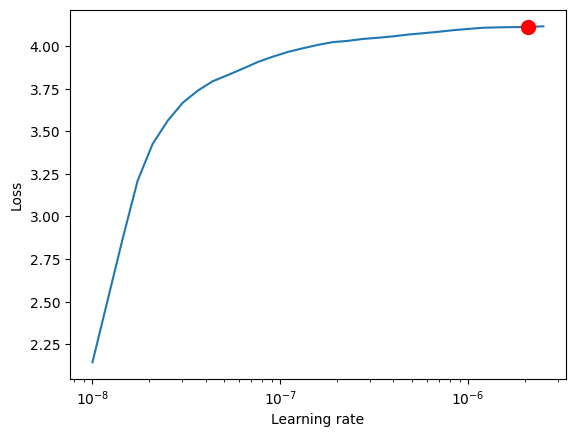

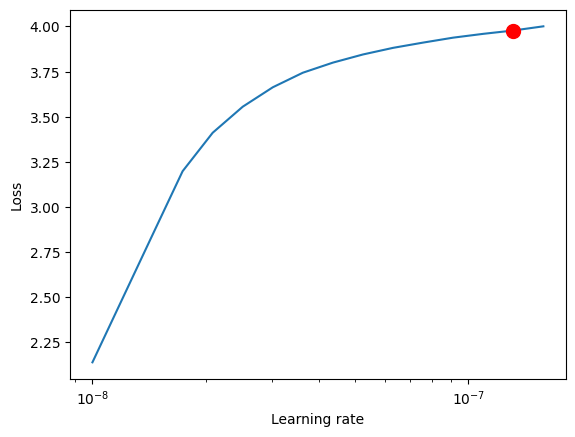

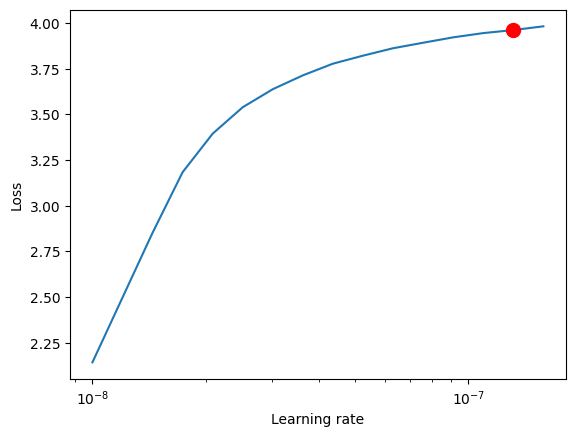

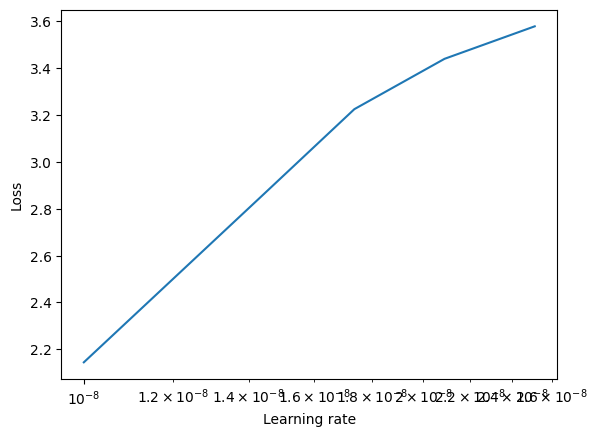

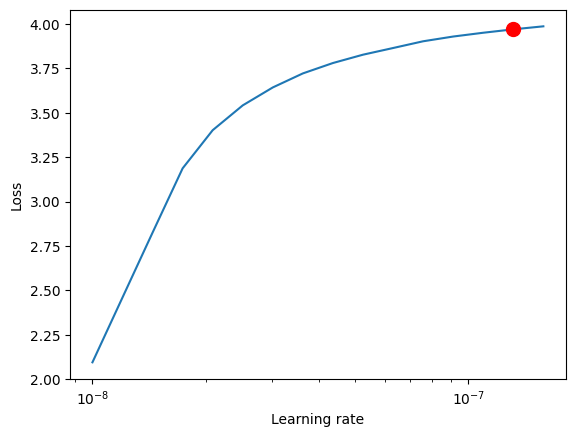

In [7]:
# Training

import random
import math
from lightning.pytorch.tuner import Tuner


for trial in range(config["trials"]):
    bs_unrounded = random.randint(config["batch_size"][0], config["batch_size"][1])
    bs = 2 ** round(math.log(bs_unrounded, 2))
    wd = 10 ** random.uniform(math.log10(config["weight_decay"][0]), math.log10(config["weight_decay"][1]))
    
    print(f"Trial {trial + 1}/{config['trials']}")
    print(f"Batch size: {bs}, Weight decay: {wd}")

    dm = DetectionDataModule(num_workers=config["workers"], batch_size=bs)
    dm.prepare_data()
    dm.setup()

    model = DetectionModel(simclr_model, dm.num_classes, wd)

    trainer = L.Trainer(
        precision="bf16-mixed",
        max_epochs=config["epochs"],
    )
    tuner = Tuner(trainer)

    lr_finder = tuner.lr_find(model, datamodule=dm)
    fig = lr_finder.plot(suggest=True)
    fig.show()

    trainer.fit(model, datamodule=dm)
    trainer.test(model, datamodule=dm)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/